In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import datetime as dt


from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import calendar
import time
import pandas as pd
import scipy.stats as sps
# import seaborn as sns
import geopandas as gpd
import geopy as gp
from geopy.distance import geodesic as gd

In [2]:
def get_gpm_path(date):
    """
    input must be datetime object
    3B42.yyyymmdd.hh.7.nc
    3B42.20090502.15.7.nc
    """
    gpm_string = '3B-DAY.MS.MRG.3IMERG.'+str(date.year)+str(date.month).zfill(2)+str(date.day).zfill(2)+'-S000000-E235959.V06.nc4.nc4'
    dir_path = '/home/users/baracoma/GPM/TC/gpm_BA_tcs/'
    gpm_path = os.path.join(dir_path, gpm_string)
    return gpm_path

In [7]:
path_out = '/home/users/baracoma/notebooks/wrf_expts/paper2'
gpm_path = '/home/users/baracoma/GPM/TC/gpm_BA_tcs/'
lf_list = pd.read_pickle(os.path.join(path_out,'lf_list_intensitywithmntrain.pkl'))
lf_list = lf_list.reindex(['KOPPU', 'NESAT', 'MEGI', 'IMBUDO', 'CIMARON', 'BEBINCA', 'NARI', 'PRAPIROON'])

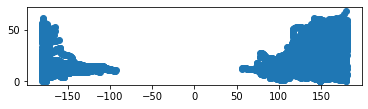

In [9]:
ibtracs_path = '/home/users/baracoma/data/gis/ibtracs/v04/IBTrACS.WP.list.v04r00.point_post_1978.shp'
ibtracs_path_line = '/home/users/baracoma/data/gis/ibtracs/v04/IBTrACS.WP.list.v04r00.line_post_1978.shp'
ibtracs = gpd.read_file(ibtracs_path)
ibtracs_line = gpd.read_file(ibtracs_path_line)
ibtracs.plot()
plt.show()

In [10]:
lat_min = 13
lat_max = 19
lon_min = 118
lon_max = 125

lat_min_5deg = lat_min-5
lat_max_5deg = lat_max+5
lon_min_5deg = lon_min-5
lon_max_5deg = lon_max+5

crs = ccrs.PlateCarree()

KOPPU
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20151016-S000000-E235959.V06.nc4.nc4
NESAT
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20110926-S000000-E235959.V06.nc4.nc4
MEGI
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20101017-S000000-E235959.V06.nc4.nc4
IMBUDO
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20030721-S000000-E235959.V06.nc4.nc4
CIMARON
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20061028-S000000-E235959.V06.nc4.nc4
BEBINCA
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20001101-S000000-E235959.V06.nc4.nc4
NARI
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20131010-S000000-E235959.V06.nc4.nc4
PRAPIROON
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20060730-S000000-E235959.V06.nc4.nc4


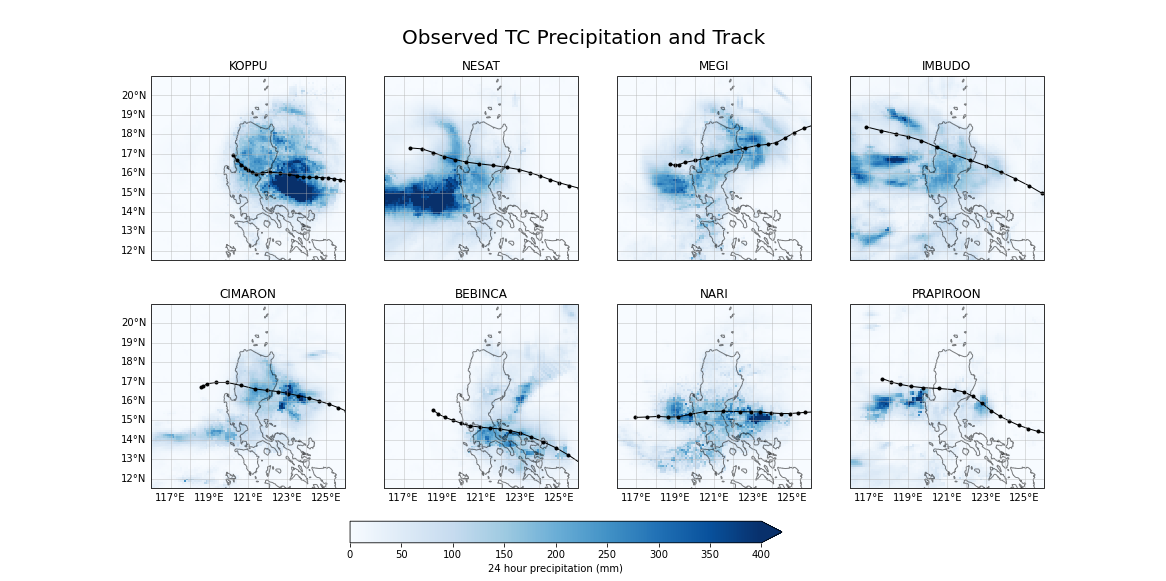

In [11]:
tc_start = -1

crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(16,8),
                         subplot_kw={'projection': crs})

i = tc_start
for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        print(tcname)
        tc_dt  = lf_list.loc[tcname].DateStr.to_pydatetime()
        tc_sid = lf_list.loc[tcname].SID
        gpm_ds = xr.open_dataset(get_gpm_path(tc_dt+dt.timedelta(hours=24)))
        print(get_gpm_path(tc_dt))
#         print(tc_dt)

        gpm_prec = gpm_ds.precipitationCal[0].sel(lat=slice(lat_min-2, lat_max+2), lon=slice(lon_min-2, lon_max+2))
        gpm_prec = gpm_prec.T

        ibtracs_tc = ibtracs.loc[ibtracs['SID'] == tc_sid]
        dt_mask = (pd.to_datetime(ibtracs_tc.ISO_TIME)<=(tc_dt+dt.timedelta(hours=47))) & (pd.to_datetime(ibtracs_tc.ISO_TIME)>=(tc_dt+dt.timedelta(hours=-12)))        
        ibtracs_tc = ibtracs_tc.loc[dt_mask]
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None

        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None        
        
        xgrid = np.arange(lon_min-10, lon_max+10, 1)
        ygrid = np.arange(lat_min-10, lat_max+10, 1)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}

        plot_gpm = axes[j,k].pcolormesh(gpm_prec.lon, gpm_prec.lat, gpm_prec, cmap='Blues', vmin=0, vmax=400)
        plot_ibtracs = axes[j,k].plot(ibtracs_tc.LON.values, ibtracs_tc.LAT.values, 'ko-', linewidth=1, markersize=3)
        axes[j,k].set_xlim((116, 126))
        axes[j,k].set_ylim((13.5-2, 19+2))   
        axes[j,k].set_title(tcname)
fig.suptitle('\nObserved TC Precipitation and Track', size=20)      
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_gpm, orientation='horizontal', ax=cbar_ax, pad=1, extend='max')
cbar.ax.set_xlabel('24 hour precipitation (mm)')
plt.savefig(os.path.join(path_out, 'gpm_track.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

KOPPU
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20151016-S000000-E235959.V06.nc4.nc4
NESAT
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20110926-S000000-E235959.V06.nc4.nc4
MEGI
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20101017-S000000-E235959.V06.nc4.nc4
IMBUDO
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20030721-S000000-E235959.V06.nc4.nc4
CIMARON
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20061028-S000000-E235959.V06.nc4.nc4
BEBINCA
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20001101-S000000-E235959.V06.nc4.nc4
NARI
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20131010-S000000-E235959.V06.nc4.nc4
PRAPIROON
/home/users/baracoma/GPM/TC/gpm_BA_tcs/3B-DAY.MS.MRG.3IMERG.20060730-S000000-E235959.V06.nc4.nc4


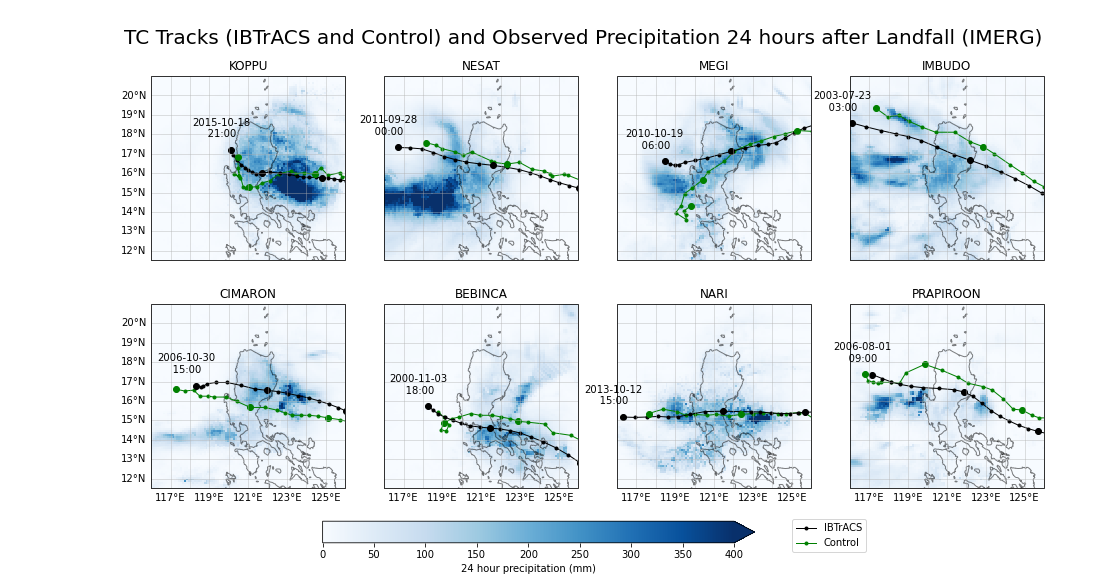

In [12]:
tc_start = -1


crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(16,8),
                         subplot_kw={'projection': crs})

i = tc_start
for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        print(tcname)
        tc = lf_list.loc[tcname]        
        tc_dt  = lf_list.loc[tcname].DateStr.to_pydatetime()
        tc_sid = lf_list.loc[tcname].SID

        gpm_ds = xr.open_dataset(get_gpm_path(tc_dt+dt.timedelta(hours=24)))
        print(get_gpm_path(tc_dt))
#         print(tc_dt)

        gpm_prec = gpm_ds.precipitationCal[0].sel(lat=slice(lat_min-2, lat_max+2), lon=slice(lon_min-2, lon_max+2))
        gpm_prec = gpm_prec.T
        
        
        tc_dt  = tc.DateStr.to_pydatetime()

        tc_dt_start = tc_dt - dt.timedelta(hours=48)
        tc_dt_end = tc_dt + dt.timedelta(hours=48)
        ibtracs_tc = ibtracs.loc[ibtracs['SID'] == tc_sid]
        
        dt_mask = (pd.to_datetime(ibtracs_tc.ISO_TIME)<=tc_dt_end) & (pd.to_datetime(ibtracs_tc.ISO_TIME)>=tc_dt_start)    
#         dt_mask = (pd.to_datetime(ibtracs_tc.ISO_TIME)>=tc_dt_start)    
        ibtracs_tc_clip = ibtracs_tc.loc[dt_mask]     
        if tcname=='BEBINCA':
            wrf_lon = tc.lon_o[11:41]
            wrf_lat = tc.lat_o[11:41]
            wrf_len = len(wrf_lon)+3
            ibt_lon = ibtracs_tc_clip.LON.values[:wrf_len]
            ibt_lat = ibtracs_tc_clip.LAT.values[:wrf_len]        

        else:
            wrf_lon = tc.lon_o[8:41]
            wrf_lat = tc.lat_o[8:41]            
            wrf_len = len(wrf_lon)
            ibt_lon = ibtracs_tc_clip.LON.values[:wrf_len]
            ibt_lat = ibtracs_tc_clip.LAT.values[:wrf_len]        

#         time_str = str(pd.to_datetime(ibtracs_tc_clip.ISO_TIME[:wrf_len].values)[-1])[:-6]+'z'        
        time_str = str(pd.to_datetime(ibtracs_tc_clip.ISO_TIME[:wrf_len].values)[-1])[:-9] + '\n     ' + str(pd.to_datetime(ibtracs_tc_clip.ISO_TIME[:wrf_len].values)[-1])[-8:-6]+':00'        
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None

        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None        
        
        xgrid = np.arange(lon_min-10, lon_max+10, 1)
        ygrid = np.arange(lat_min-10, lat_max+10, 1)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}

        plot_gpm = axes[j,k].pcolormesh(gpm_prec.lon, gpm_prec.lat, gpm_prec, cmap='Blues', vmin=0, vmax=400)
        plot_wrf, = axes[j,k].plot(wrf_lon, wrf_lat, 'go-', label='Control', linewidth=1, markersize=3)
        plot_ibtracs, = axes[j,k].plot(ibt_lon, ibt_lat, 'ko-', label='IBTrACS', linewidth=1, markersize=3)
        
        axes[j,k].plot(wrf_lon[::8], wrf_lat[::8], 'go', linewidth=1, markersize=6)    
        axes[j,k].plot(ibt_lon[::8], ibt_lat[::8], 'ko', linewidth=1, markersize=6)    
        axes[j,k].text(ibt_lon[-1]-2, ibt_lat[-1]+.65, time_str, size=10)        
        
        axes[j,k].set_xlim((116, 126))
        axes[j,k].set_ylim((13.5-2, 19+2))   
        axes[j,k].set_title(tcname)
fig.suptitle('\nTC Tracks (IBTrACS and Control) and Observed Precipitation 24 hours after Landfall (IMERG)', size=20)      
# fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
# cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
# cbar_ax.spines['top'].set_visible(False)
# cbar_ax.spines['right'].set_visible(False)
# cbar_ax.spines['bottom'].set_visible(False)
# cbar_ax.spines['left'].set_visible(False)
# cbar_ax.set_xticks([])
# cbar_ax.set_yticks([])
# cbar = fig.colorbar(plot_gpm, orientation='horizontal', ax=cbar_ax, pad=1, extend='max')
# cbar.ax.set_xlabel('24 hour precipitation (mm)')
fig.legend((plot_ibtracs, plot_wrf), ('IBTrACS', 'Control'), bbox_to_anchor=(0.75, 0.1))
cbar_ax = fig.add_axes([0., 0.05, 0.95, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_gpm, orientation='horizontal', ax=cbar_ax, pad=1, extend='max')
cbar.ax.set_xlabel('24 hour precipitation (mm)')
# fig.legend((plot_track_o), ('Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)

plt.savefig(os.path.join(path_out, 'tracks_obsctrlgpm.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()